<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('defi-ia-2022').getOrCreate()
df = spark.read.csv("Train/Train/X_station_train.csv", header = True, inferSchema = True)
df.printSchema()

root
 |-- number_sta: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- ff: double (nullable = true)
 |-- t: double (nullable = true)
 |-- td: double (nullable = true)
 |-- hu: double (nullable = true)
 |-- dd: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- Id: string (nullable = true)



In [2]:
df = df.dropna()

In [3]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,number_sta,date,ff,t,td,hu,dd,precip,Id
0,14066001,2016-01-01 00:00:00,3.05,279.28,277.97,91.4,200.0,0.0,14066001_0_0
1,14066001,2016-01-01 01:00:00,2.57,278.76,277.45,91.4,190.0,0.0,14066001_0_1
2,14066001,2016-01-01 02:00:00,2.26,278.27,277.02,91.7,181.0,0.0,14066001_0_2
3,14066001,2016-01-01 03:00:00,2.62,277.98,276.95,93.0,159.0,0.0,14066001_0_3
4,14066001,2016-01-01 04:00:00,2.99,277.32,276.72,95.9,171.0,0.0,14066001_0_4


In [4]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'double']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ff,2264105,3.5626832615242234,2.3788827064914044,0.0,32.22
t,2264105,284.9216108189548,6.39907668762727,262.13,325.07000000000005
td,2264105,281.3762233347189,5.243936134064149,222.35,324.67
hu,2264105,80.85707310166372,15.094746532612463,1.0,100.0
dd,2264105,190.97439686476204,94.56718561324305,0.0,360.0
precip,2264105,0.08196117229546712,0.4505563941987064,0.0,48.0


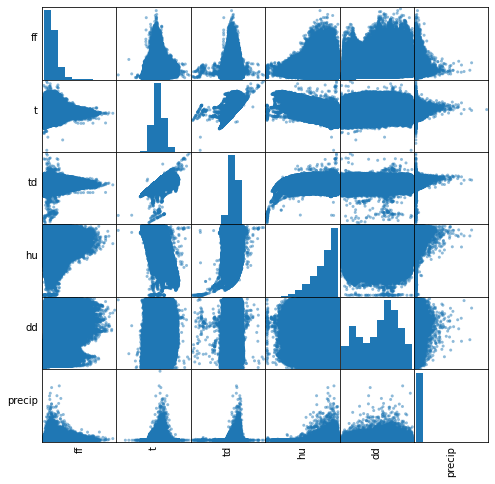

In [17]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8))
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [20]:
df.printSchema()

root
 |-- number_sta: integer (nullable = true)
 |-- ff: double (nullable = true)
 |-- t: double (nullable = true)
 |-- td: double (nullable = true)
 |-- hu: double (nullable = true)
 |-- dd: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- Id: string (nullable = true)



In [5]:
df = df.select('number_sta', 'ff', 't', 'td', 'hu', 'dd', 'precip', 'Id')

In [6]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['number_sta', 'Id']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Id', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['ff', 't', 'td', 'hu', 'dd', 'precip']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [7]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
#df = pipelineModel.transform(df)
#selectedCols = ['label', 'features'] + cols
#df = df.select(selectedCols)
#df.printSchema()

Py4JJavaError: An error occurred while calling o75.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 14.0 failed 1 times, most recent failure: Lost task 0.0 in stage 14.0 (TID 65) (DESKTOP-T857H8B executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.catalyst.expressions.codegen.BufferHolder.grow(BufferHolder.java:80)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.grow(UnsafeWriter.java:63)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.writeUnalignedBytes(UnsafeWriter.java:127)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.write(UnsafeWriter.java:118)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.write(UnsafeWriter.java:114)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateResultProjection$5(AggregationIterator.scala:260)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$Lambda$3843/0x0000000801a77970.apply(Unknown Source)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:96)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:32)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:350)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2508/0x00000008017ae0e0.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.RDD$$Lambda$2505/0x00000008017ad678.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2470/0x000000080179a2c8.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:394)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:338)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:366)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:338)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3715)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:2971)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:2971)
	at org.apache.spark.ml.feature.StringIndexer.countByValue(StringIndexer.scala:204)
	at org.apache.spark.ml.feature.StringIndexer.sortByFreq(StringIndexer.scala:212)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:242)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:64)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.catalyst.expressions.codegen.BufferHolder.grow(BufferHolder.java:80)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.grow(UnsafeWriter.java:63)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.writeUnalignedBytes(UnsafeWriter.java:127)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.write(UnsafeWriter.java:118)
	at org.apache.spark.sql.catalyst.expressions.codegen.UnsafeWriter.write(UnsafeWriter.java:114)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateResultProjection$5(AggregationIterator.scala:260)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$Lambda$3843/0x0000000801a77970.apply(Unknown Source)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:96)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:32)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:350)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2508/0x00000008017ae0e0.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.RDD$$Lambda$2505/0x00000008017ad678.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2470/0x000000080179a2c8.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	... 1 more


In [24]:
df.printSchema()

root
 |-- number_sta: integer (nullable = true)
 |-- ff: double (nullable = true)
 |-- t: double (nullable = true)
 |-- td: double (nullable = true)
 |-- hu: double (nullable = true)
 |-- dd: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- Id: string (nullable = true)

